### Visualizing dataset for presentation purposes

In [13]:
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from shared.data import SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED
import numpy as np
from xhistogram.xarray import histogram

In [14]:
data_path = Path("data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       3,       4,       5,       7,      13,      25,
            24,      35,      50,      90,      91,     152,     236,
           384,     677,    1175,    2050,    3610,    6589,   12182,
         22481,   41216,   75682,  137299,  245339,  424108,  694149,
       1042692, 1362899, 1484707, 1318195,  975953,  635438,  382110,
        220841,  126142,   71072,   41185,   23788,   13946,    8372,
          4814,    3043,    1741,    1121,     682,     416,     220,
           152,      96,      56,      28,      27,      16,      11,
             6,       0,       2])
Coordinates:
  * data_bin  (data_bin) float64 -57.9 -55.97 -54.03 -52.1 ... 50.44 52.37 54.31

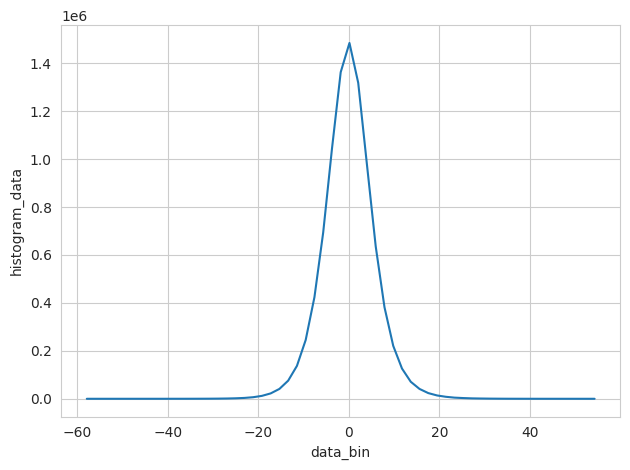

In [9]:
# Histogram of all values in dataset
# EEG data is already re-referenced to average value in preprocessing, so should be close to normal
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

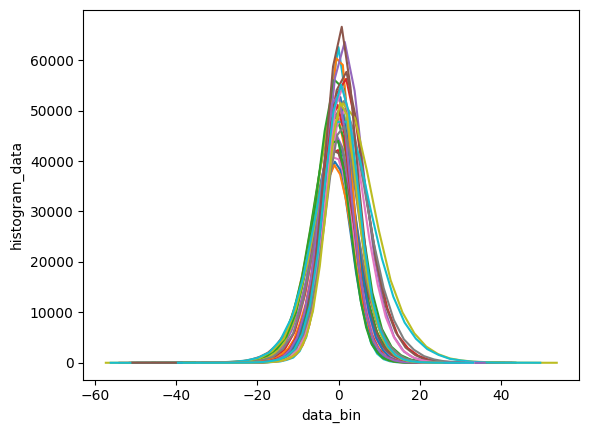

In [36]:
# Checking distribution for each channels, this means no within channel normalization is necessary
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    # display(hist)
    hist.plot()

In [ ]:
sample_length = data.sel(channels="Fp1").data.isnull().idxmax("samples")
# Count occurences where length of samples for a label is higher than 100
np.count_nonzero(~np.isnan(sample_length.where(sample_length > 100).to_numpy()))

In [15]:
acc_data = data.where(data.cue == "AC", drop=True)
sp_data = data.where(data.cue == "SP", drop=True)

In [16]:
max_idx_acc = (
    acc_data.sel(channels="Fp1", labels=SAT1_STAGES_ACCURACY)
    .data.isnull()
    .idxmax("samples")
)
avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

max_idx_sp = (
    sp_data.sel(channels="Fp1", labels=SAT1_STAGES_SPEED)
    .data.isnull()
    .idxmax("samples")
)
avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

In [6]:
# max_idx_acc = acc_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_acc = max_idx_acc.where(max_idx_acc != 0).mean(dim="epochs", skipna=True)

# max_idx_sp = sp_data.sel(channels="Fp1").data.isnull().idxmax("samples")
# avg_sp = max_idx_sp.where(max_idx_sp != 0).mean(dim="epochs", skipna=True)

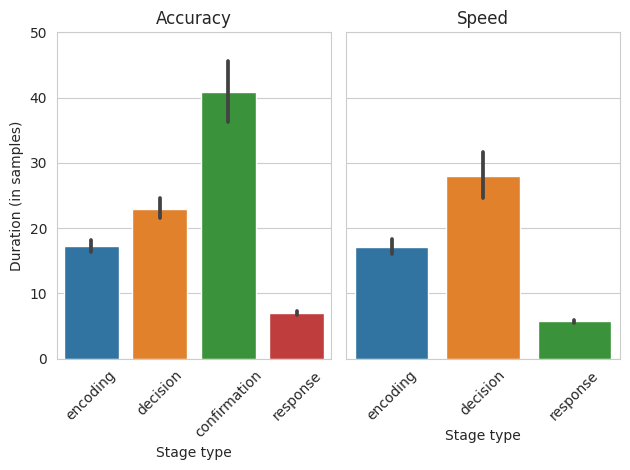

In [17]:
sns.set_style("whitegrid")

plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

plt.setp(axes, ylim=(0, 50), xlabel="Stage type")

plot1 = sns.barplot(avg_acc, ax=axes[0])
plot2 = sns.barplot(avg_sp, ax=axes[1])
plot1.set_xticklabels(avg_acc.labels.to_numpy(), rotation=45)
plot1.set_ylabel("Duration (in samples)")
plot1.set_title("Accuracy")
# plot1.set_xlabel("Stage")
# plot1.set_ylabel("Duration in samples")
plot2.set_xticklabels(avg_sp.labels.to_numpy(), rotation=45)
plot2.set_yticklabels([])
plot2.set_title("Speed")
# plot2.set_xlabel("Stage")
# plot2.set_ylabel("Duration in samples")

plt.show()

In [79]:
data_n = data.sel(
    participant="0021",
    channels="Fp1",
    labels="encoding",
    epochs=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
)

In [83]:
sns.scatterplot(data=data_n, x="samples", y="data")

ValueError: Data must be 1-dimensional, got ndarray of shape (11, 157) instead

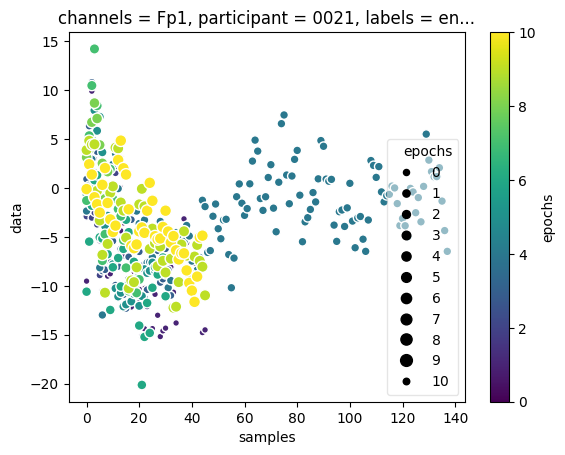

In [73]:
plt.show()

In [51]:
data.sel(participant="0021", channels="Fp1", labels="encoding", epochs=[0]).data

<xarray.DataArray 'data' (epochs: 1, samples: 157)>
array([[ -0.18200085,  -0.80526227,   1.35877502,   3.02365875,
         -0.02237152,  -2.25271702,  -2.42085075,   0.2947644 ,
         -0.91509807,  -5.1842823 ,  -1.44319379,  -0.2521725 ,
         -2.26326203,   0.07126679,  -3.59668231,  -6.76995134,
         -5.46194267,  -7.99716139,  -8.59681225,  -9.54486752,
        -11.66129684,  -9.17194557, -10.2177906 , -11.75735283,
         -8.43788433,  -7.39112139,  -6.80812454,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan]])
Coordinates:
    channels     <U3 'Fp1'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 150 151 152 153 154 155 156
  * epochs       (epochs) int64 0
    participant  <U4 '0021'
    labels       <U8 'encoding'
    stim         (epochs) float64 2.0
    resp         (epochs) object 'resp_right'
    rt           (epochs) float64 1.388
    cue          (epochs) object 'AC'
    movement     (epochs) object 'stim_right'
    trigger      (epochs) object 'AC/stim_right/resp_right'